### GRADOS-HORA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# CONFIG DATOS

archivo = "TEMP HISTÓRICA.xlsx"
sheet_name = "330020_XXXX_Temperatura_"

df = pd.read_excel(archivo, sheet_name=sheet_name)

df["FECHA HORA"] = pd.to_datetime(df["FECHA HORA"], errors="coerce")
df = df.dropna(subset=["FECHA HORA", "TEMP"]).sort_values("FECHA HORA")
df = df.set_index("FECHA HORA")

In [3]:
# INVIERNO / VERANO
y = 10
fin = df.index.max()
inicio = fin - pd.DateOffset(years=y)
df_20 = df.loc[inicio:fin].copy()

# Por hora
df_20_h = df_20.resample("h").interpolate()

meses_verano   = [12, 1, 2, 3]
meses_invierno = [6, 7, 8, 9]
verano_h   = df_20_h[df_20_h.index.month.isin(meses_verano)].copy()
invierno_h = df_20_h[df_20_h.index.month.isin(meses_invierno)].copy()

Tref_verano   = 24  # Referencia de verano
Tref_invierno = 21  # Referencia de invierno al azar pusimos 19 grados, ver si citar o cambiarlo 

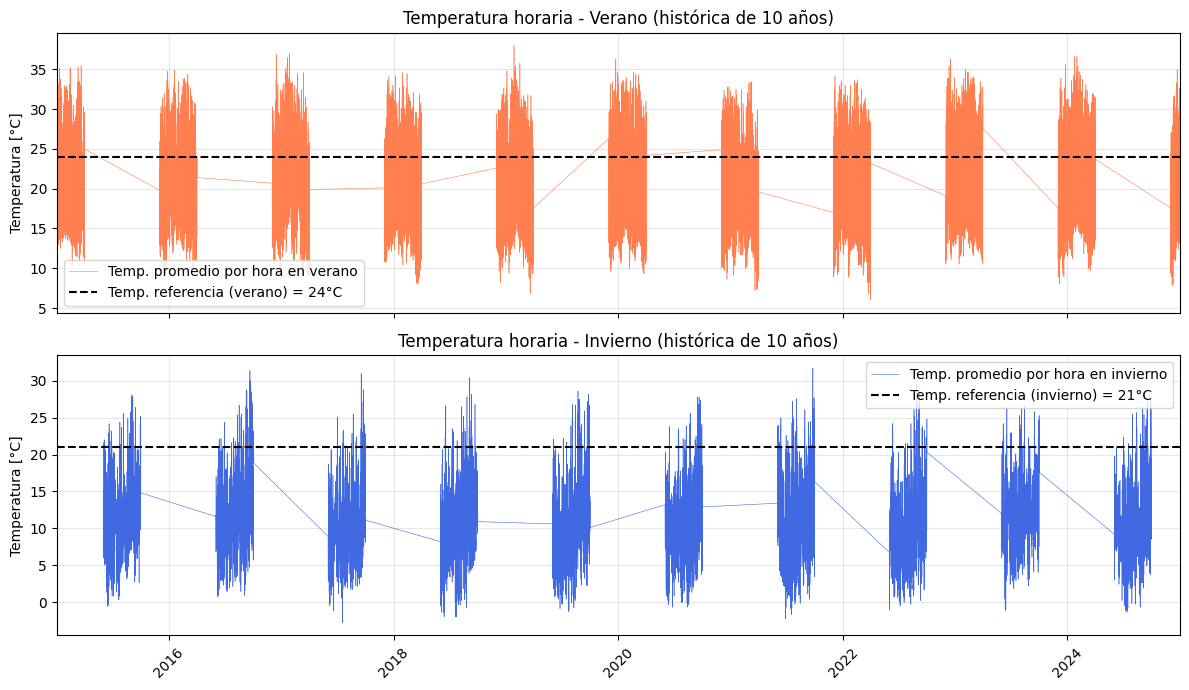

In [4]:
# TEMPERATURAS 20 AÑOS

fig, (ax_ver, ax_inv) = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

xmin = df_20_h.index.min()
xmax = df_20_h.index.max()

# VERANO
ax_ver.plot(verano_h.index, verano_h["TEMP"], lw=0.4, color="coral",
            label="Temp. promedio por hora en verano")
ax_ver.axhline(Tref_verano, ls="--", color="k",
               label=f"Temp. referencia (verano) = {Tref_verano}°C")
ax_ver.set_title(f"Temperatura horaria - Verano (histórica de {y} años)")
ax_ver.set_ylabel("Temperatura [°C]")
ax_ver.legend()
ax_ver.grid(alpha=0.3)
ax_ver.set_xlim(xmin, xmax)

# INVIERNO
ax_inv.plot(invierno_h.index, invierno_h["TEMP"], lw=0.4, color="royalblue",
            label="Temp. promedio por hora en invierno")
ax_inv.axhline(Tref_invierno, ls="--", color="k",
               label=f"Temp. referencia (invierno) = {Tref_invierno}°C")
ax_inv.set_title(f"Temperatura horaria - Invierno (histórica de {y} años)")
ax_inv.set_ylabel("Temperatura [°C]")
ax_inv.legend()
ax_inv.grid(alpha=0.3)
ax_inv.set_xlim(xmin, xmax)

for ax in (ax_ver, ax_inv):
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()


In [5]:
# AQUI PARA FILTRAR LAS HORAS DE OCUPACIÓN

import datetime as dt

hora_ini = dt.time(8, 0)    # 8:00
hora_fin = dt.time(18, 0)   # 18:00

def solo_horas_ocupadas(df):
    return df[(df.index.time >= hora_ini) & (df.index.time < hora_fin)]
    
verano_occ   = solo_horas_ocupadas(verano_h).copy()
invierno_occ = solo_horas_ocupadas(invierno_h).copy()

In [6]:
# DÍA REPRESENTATIVO

verano_occ["hora"] = verano_occ.index.hour
invierno_occ["hora"] = invierno_occ.index.hour

verano_dia_rep = verano_occ.groupby("hora")["TEMP"].quantile(0.90)
invierno_dia_rep = invierno_occ.groupby("hora")["TEMP"].quantile(0.10)

In [7]:
idx_dia_2025 = pd.date_range(
    "2025-01-01 08:00", 
    "2025-01-01 17:00",
    freq="h"
)
verano_rep_dia = pd.Series(verano_dia_rep.values, index=idx_dia_2025)
invierno_rep_dia = pd.Series(invierno_dia_rep.values, index=idx_dia_2025)

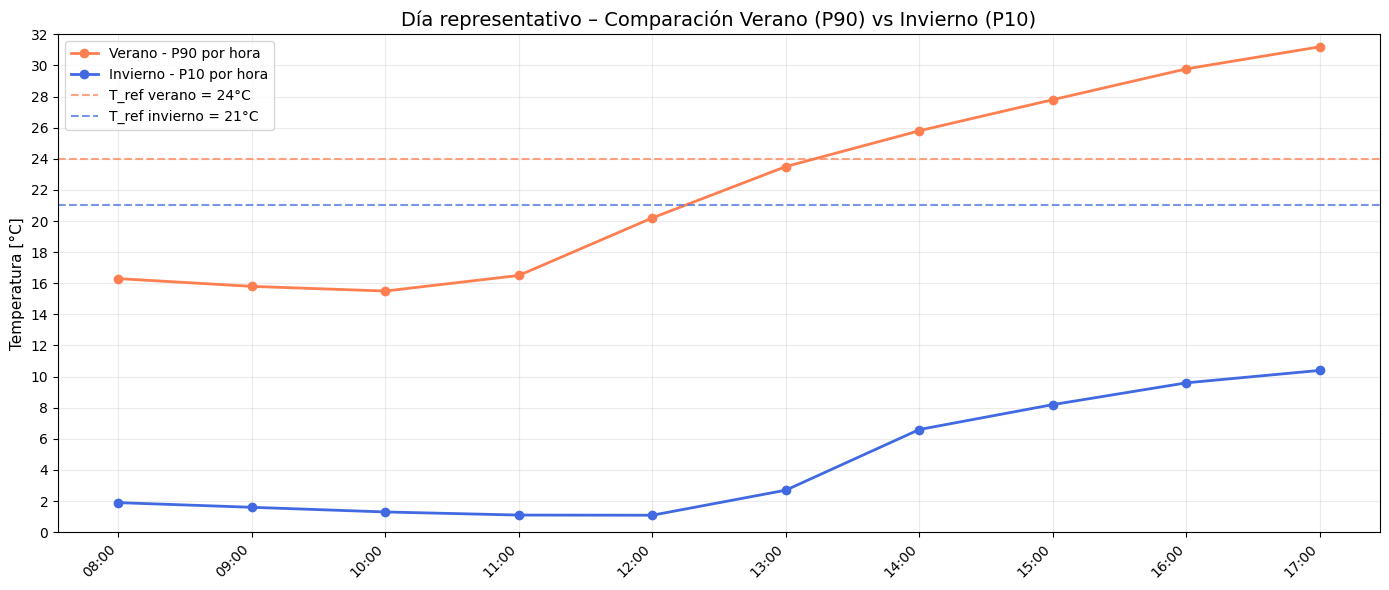

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

fig, ax = plt.subplots(figsize=(14,6))

# Temperatura día representativo VERANO
ax.plot(verano_rep_dia.index, verano_rep_dia, marker="o", lw=2,
        color="coral", label="Verano - P90 por hora")

# Temperatura día representativo INVIERNO
ax.plot(invierno_rep_dia.index, invierno_rep_dia, marker="o", lw=2,
        color="royalblue", label="Invierno - P10 por hora")

# Líneas de referencia
ax.axhline(Tref_verano,   ls="--", color="coral",  alpha=0.7,
           label=f"T_ref verano = {Tref_verano}°C")
ax.axhline(Tref_invierno, ls="--", color="royalblue", alpha=0.7,
           label=f"T_ref invierno = {Tref_invierno}°C")

# Formato eje Y (mismo para ambos)
ax.set_ylim(0, 32)
ax.yaxis.set_major_locator(plt.MultipleLocator(2))
ax.set_ylabel("Temperatura [°C]", fontsize=11)

# Formato eje X
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Título y grilla
ax.set_title("Día representativo – Comparación Verano (P90) vs Invierno (P10)",
             fontsize=14)
ax.grid(alpha=0.25)

# Leyenda
ax.legend(loc="upper left", fontsize=10)

plt.tight_layout()
plt.show()


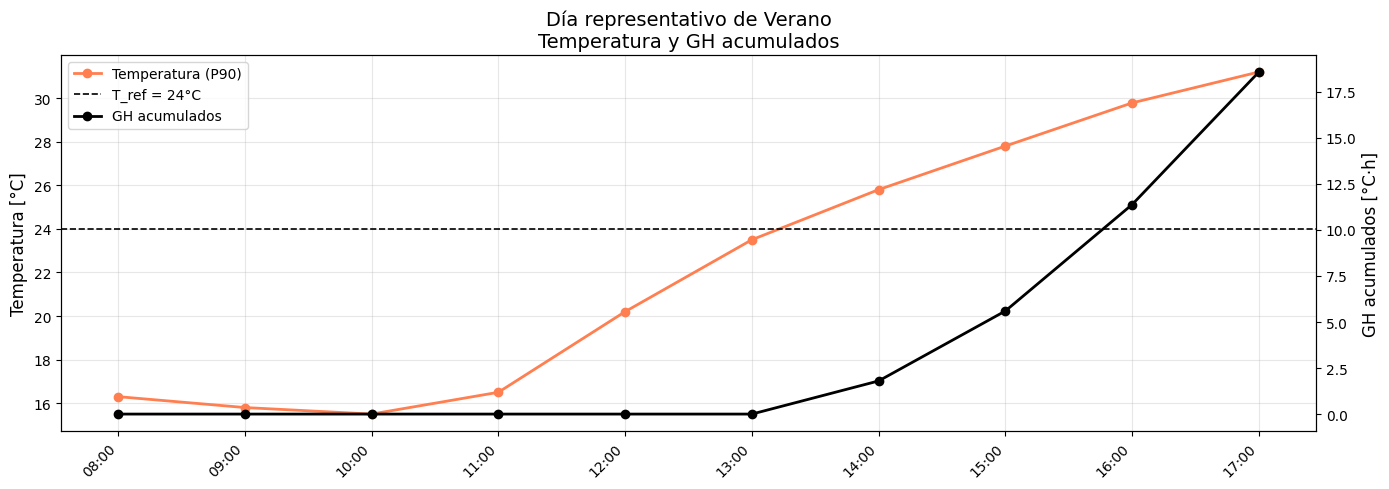

In [9]:
# GH por hora del día representativo (verano)
GH_ver_h = np.clip(verano_rep_dia - Tref_verano, 0, None)
GH_ver_cum = GH_ver_h.cumsum()

fig, ax1 = plt.subplots(figsize=(14,5))

ax1.plot(verano_rep_dia.index, verano_rep_dia.values, marker="o",
         color="coral", lw=2, label="Temperatura (P90)")
ax1.axhline(Tref_verano, ls="--", color="k", lw=1.2,
            label=f"T_ref = {Tref_verano}°C")
ax1.set_ylabel("Temperatura [°C]", fontsize=12)
ax1.set_title("Día representativo de Verano\nTemperatura y GH acumulados", fontsize=14)
ax1.grid(alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(verano_rep_dia.index, GH_ver_cum, marker="o",
         color="black", lw=2, label="GH acumulados")
ax2.set_ylabel("GH acumulados [°C·h]", fontsize=12)

ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.tight_layout()
plt.show()

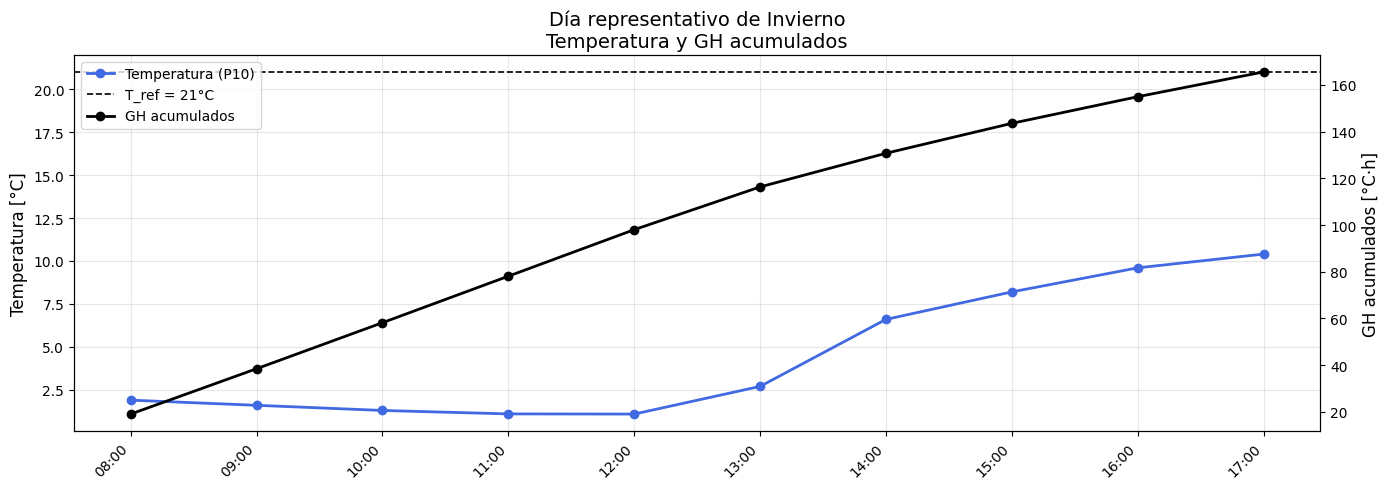

In [10]:
# GH por hora del día representativo (invierno)
GH_inv_h = np.clip(Tref_invierno - invierno_rep_dia, 0, None)
GH_inv_cum = GH_inv_h.cumsum()

fig, ax1 = plt.subplots(figsize=(14,5))

ax1.plot(invierno_rep_dia.index, invierno_rep_dia.values, marker="o",
         color="royalblue", lw=2, label="Temperatura (P10)")
ax1.axhline(Tref_invierno, ls="--", color="k", lw=1.2,
            label=f"T_ref = {Tref_invierno}°C")
ax1.set_ylabel("Temperatura [°C]", fontsize=12)
ax1.set_title("Día representativo de Invierno\nTemperatura y GH acumulados", fontsize=14)
ax1.grid(alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(invierno_rep_dia.index, GH_inv_cum, marker="o",
         color="black", lw=2, label="GH acumulados")
ax2.set_ylabel("GH acumulados [°C·h]", fontsize=12)

ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.tight_layout()
plt.show()

In [11]:
GH_dia_ver = GH_ver_h.sum()
GH_dia_inv = GH_inv_h.sum()

print(f"GH día representativo de VERANO:  {GH_dia_ver:.2f} °C.h")
print(f"GH día representativo de INVIERNO: {GH_dia_inv:.2f} °C.h")

GH día representativo de VERANO:  18.58 °C.h
GH día representativo de INVIERNO: 165.51 °C.h


### HUMEDAD

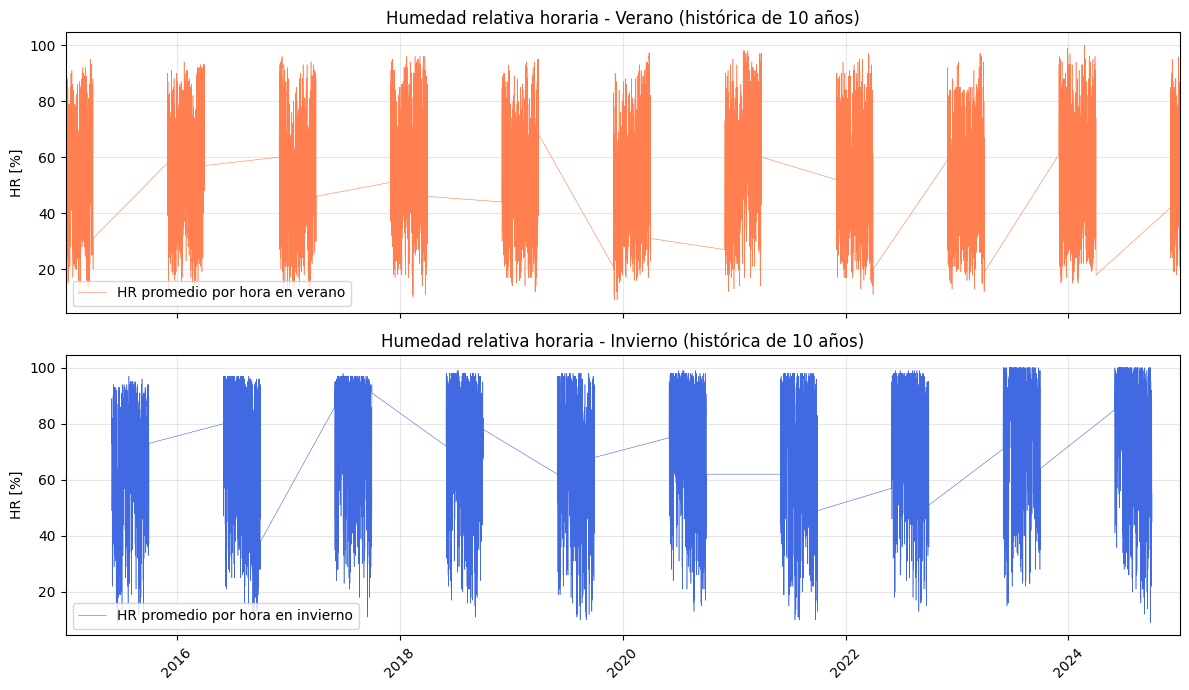

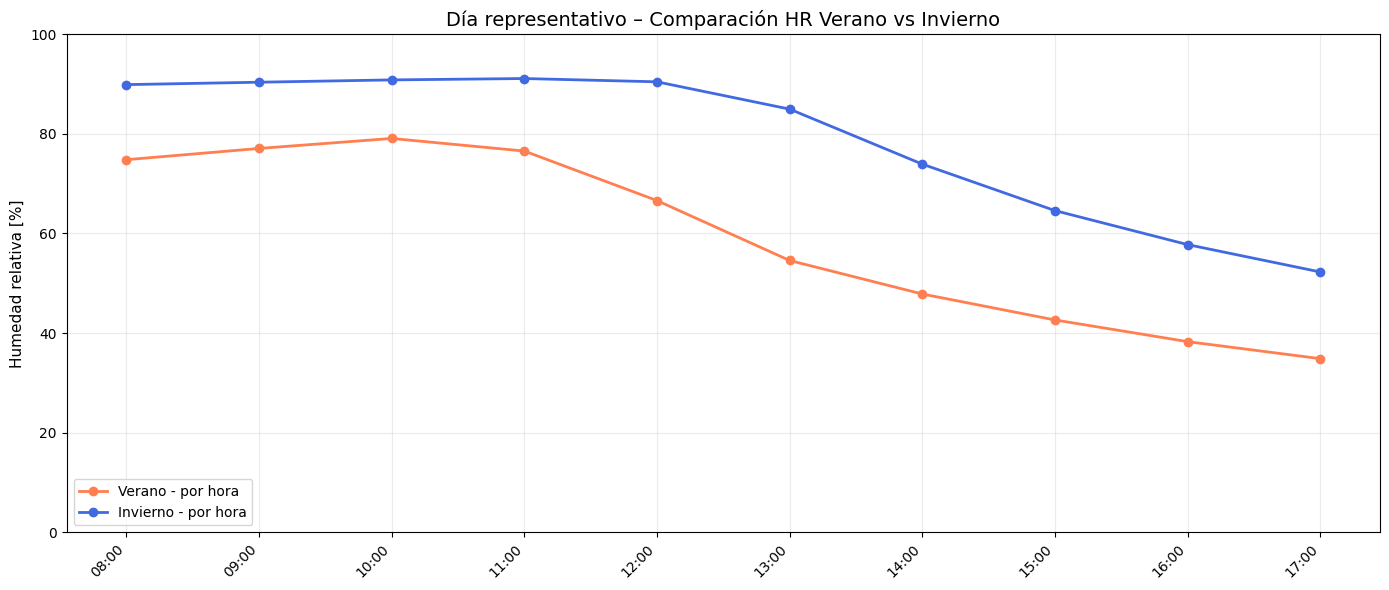

In [12]:
# CONFIG DATOS HUMEDAD

archivo_h = "HR HISTÓRICA.xlsx"
sheet_name_h = "330020_XXXX_Humedad_"

dfh = pd.read_excel(archivo_h, sheet_name=sheet_name_h)

dfh["FECHA HORA"] = pd.to_datetime(dfh["FECHA HORA"], errors="coerce")
dfh = dfh.dropna(subset=["FECHA HORA", "HR"]).sort_values("FECHA HORA")
dfh = dfh.set_index("FECHA HORA")

# INVIERNO / VERANO

fin_h = dfh.index.max()
inicio_h = fin_h - pd.DateOffset(years=y)
dfh_20 = dfh.loc[inicio_h:fin_h].copy()

# 🔧 eliminar duplicados promediando por timestamp
dfh_20 = dfh_20.groupby(level=0).mean()

# Por hora
dfh_20_h = dfh_20.resample("h").interpolate()

meses_verano   = [12, 1, 2, 3]
meses_invierno = [6, 7, 8, 9]

verano_hum   = dfh_20_h[dfh_20_h.index.month.isin(meses_verano)].copy()
invierno_hum = dfh_20_h[dfh_20_h.index.month.isin(meses_invierno)].copy()


# GRAFICAR HUMEDAD HISTÓRICA

fig, (ax_ver_h, ax_inv_h) = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

xmin_h = dfh_20_h.index.min()
xmax_h = dfh_20_h.index.max()

# VERANO HR
ax_ver_h.plot(verano_hum.index, verano_hum["HR"], lw=0.4, color="coral",
              label="HR promedio por hora en verano")
ax_ver_h.set_title(f"Humedad relativa horaria - Verano (histórica de {y} años)")
ax_ver_h.set_ylabel("HR [%]")
ax_ver_h.grid(alpha=0.3)
ax_ver_h.legend(loc="lower left")
ax_ver_h.set_xlim(xmin_h, xmax_h)

# INVIERNO HR
ax_inv_h.plot(invierno_hum.index, invierno_hum["HR"], lw=0.4, color="royalblue",
              label="HR promedio por hora en invierno")
ax_inv_h.set_title(f"Humedad relativa horaria - Invierno (histórica de {y} años)")
ax_inv_h.set_ylabel("HR [%]")
ax_inv_h.grid(alpha=0.3)
ax_inv_h.legend(loc="lower left")
ax_inv_h.set_xlim(xmin_h, xmax_h)

for ax in (ax_ver_h, ax_inv_h):
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

# FILTRAR HORAS DE OCUPACIÓN

verano_hum_occ   = solo_horas_ocupadas(verano_hum).copy()
invierno_hum_occ = solo_horas_ocupadas(invierno_hum).copy()

# DÍA REPRESENTATIVO

verano_hum_occ["hora"] = verano_hum_occ.index.hour
invierno_hum_occ["hora"] = invierno_hum_occ.index.hour

hum_verano_rep = verano_hum_occ.groupby("hora")["HR"].mean()            # LO HICE CON EL PROMEDIO???
hum_invierno_rep = invierno_hum_occ.groupby("hora")["HR"].mean()

# Índice 2025 (mismas horas que definiste antes)
idx_dia_2025_h = pd.date_range(
    "2025-01-01 08:00",
    "2025-01-01 17:00",
    freq="h"
)

hum_verano_dia = pd.Series(hum_verano_rep.values, index=idx_dia_2025_h)
hum_invierno_dia = pd.Series(hum_invierno_rep.values, index=idx_dia_2025_h)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(14,6))

ax.plot(hum_verano_dia.index, hum_verano_dia.values,
        marker="o", lw=2, color="coral",
        label="Verano - por hora")

ax.plot(hum_invierno_dia.index, hum_invierno_dia.values,
        marker="o", lw=2, color="royalblue",
        label="Invierno - por hora")

ax.set_ylim(0, 100)
ax.set_ylabel("Humedad relativa [%]", fontsize=11)

ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

ax.set_title("Día representativo – Comparación HR Verano vs Invierno",
             fontsize=14)
ax.grid(alpha=0.25)
ax.legend(loc="lower left", fontsize=10)

plt.tight_layout()
plt.show()


### COMPILADO

In [13]:
import pandas as pd

idx = verano_rep_dia.index  
df_rep = pd.DataFrame(index=idx)
df_rep["Hora"] = df_rep.index.strftime("%H:%M")

df_rep["T_verano_P90_°C"]       = verano_rep_dia.values
df_rep["GH_ver_h_°C_h"]         = GH_ver_h.values
df_rep["GH_ver_cum_°C_h"]       = GH_ver_cum.values
df_rep["HR_verano_P90_%"]       = hum_verano_dia.values

df_rep["T_invierno_P10_°C"]     = invierno_rep_dia.values
df_rep["GH_inv_h_°C_h"]         = GH_inv_h.values
df_rep["GH_inv_cum_°C_h"]       = GH_inv_cum.values
df_rep["HR_invierno_P10_%"]     = hum_invierno_dia.values

df_rep_out = df_rep.reset_index(drop=True)

df_rep_out.to_csv("DIA_REPRESENTATIVO_COMPLETO.csv", index=False)

df = df_rep_out

# Promedio de HR_verano_P90_%
promedio_hr_verano = df["HR_verano_P90_%"].mean()
Tv = df["T_verano_P90_°C"].mean()
display(df)
print("\nPromedio HR_verano_P90_%:", promedio_hr_verano," a T=",Tv)
# Promedio de HR_invierno_P10_% 
promedio_hr_invierno = df["HR_invierno_P10_%"].mean()
Ti = df["T_invierno_P10_°C"].mean()
print("\nPromedio HR_invierno_P10_% :", promedio_hr_invierno," a T=",Ti)

,Hora,T_verano_P90_°C,GH_ver_h_°C_h,GH_ver_cum_°C_h,HR_verano_P90_%,T_invierno_P10_°C,GH_inv_h_°C_h,GH_inv_cum_°C_h,HR_invierno_P10_%
0,08:00,16.30,0.00,0.00,74.818717,1.90,19.10,19.10,89.898060
1,09:00,15.80,0.00,0.00,77.080925,1.60,19.40,38.50,90.382623
2,10:00,15.50,0.00,0.00,79.086633,1.30,19.70,58.20,90.847131
3,11:00,16.50,0.00,0.00,76.554584,1.10,19.90,78.10,91.122377
4,12:00,20.20,0.00,0.00,66.608850,1.09,19.91,98.01,90.462377
5,13:00,23.50,0.00,0.00,54.572102,2.70,18.30,116.31,84.976721
6,14:00,25.80,1.80,1.80,47.842292,6.60,14.40,130.71,73.927049
7,15:00,27.80,3.80,5.60,42.629217,8.20,12.80,143.51,64.591721
8,16:00,29.78,5.78,11.38,38.273108,9.60,11.40,154.91,57.762459
9,17:00,31.20,7.20,18.58,34.853273,10.40,10.60,165.51,52.266475



Promedio HR_verano_P90_%: 59.23197011013169  a T= 22.238

Promedio HR_invierno_P10_% : 78.62369945355191  a T= 4.449


# calculo carga térmica

In [14]:
# invierno====================
import sympy as sp

altura = 2.77

altura_ventana = 2.65
altura_ventana2 = 1.56 #medido regla de 3
#m aire

m_a_of_inv = 0.02542 #kg/s
m_a_of_ver = 0.03354 #kg/s

m_a_salaprofes_inv = 0.09152 
m_a_salaprofes_ver = 0.1207

m_a_salaestudio_inv = 0.1877
m_a_salaestudio_ver = 0.2415

def h(W,T):
    return (T + W*(4.18*T+2501))*1000 #asi trabajamos todo en W

Q_gen_of = 378.88 #W
Q_gen_salaprofes = 1111.968 #W
Q_gen_salaestudio = 3483.936 #W


#factores U
UT1 = 0.53   # W/(m^2·K)
UT2 = 0.53   # W/(m^2·K)
UT3 = 0.53 
UT4 = 0.50               # W/(m^2·K)
UT5 = 0.55               # W/(m^2·K)
UT6 = 0.66               # W/(m^2·K)
UT7 = 0.24               # W/(m^2·K)

U_cielo   = 1.27         # W/(m^2·K)  se considera el de invierno 
U_piso    = 2.10         # W/(m^2·K)
U_muro_ext = 3.50        # W/(m^2·K)
U_ventana = 2.80         # W/(m^2·K)
U_mv = 4.12                                      
Upm = 1.49                                       
kt = 2.07               #del piso sala de estudio


#humedades
W_int_inv = 0.0075
W_int_ver = 0.012

W_out_inv = 0.004146
W_out_ver = 0.009883


#areas piso y cielo
A_of_inicio = 16.46
A_of = 16.28
A_of_final = 15.87 #todo en m2


A_sala_prof = 185.48 

A_sala_est = 36

#todas las variables

for i in range(2, 17, 2):
    globals()[f"T{i}"] = sp.symbols(f"T{i}")

# ---- Crear variables Qi (impares entre 1 y 17) ----
for i in range(1, 18, 2):
    globals()[f"Q{i}"] = sp.symbols(f"Q{i}")    #todas las Q van quedando en Wh al resolver 

# ---- Crear T18, T19, T20 ----
for i in [21]:
    globals()[f"Q{i}"] = sp.symbols(f"Q{i}")




# (Opcional) Si quieres todo junto en una lista:
all_vars = [
    *[globals()[f"T{i}"] for i in range(2, 17, 2)],
    *[globals()[f"Q{i}"] for i in range(1, 18, 2)], Q21
]


T1 = T3 = T5 = T7 = T9 = T11 = T13 = T15 =T17 = T21 = 21    
delta = 3 # se predefine 5 grados 
T18 = T19 = T20 =T22= T1 - delta #igual solo se usa el delta
delta_norte = 2


sols = []
for i in range(df.shape[0]):
    Text = df["T_invierno_P10_°C"][i]
    GH = df["GH_inv_h_°C_h"][i]
    # --- Definir ecuaciones  todas en hora ---
    eqs = [
        #las primeras oficinas
        sp.Eq(Q1+   Q_gen_of ,( m_a_of_inv*(h(W_int_inv,T1)  -   h(W_int_inv,Text))     + U_piso*   A_of_inicio *delta         
                                             +    U_cielo*   A_of_inicio *GH    + ( UT4/2)* (altura*4.835   )*delta  + U_ventana*GH*(3.79*altura_ventana)  + U_muro_ext*GH*(3.79*(altura - altura_ventana))  
                                                + UT4*(T1-T2)*(altura*4.835)  + U_mv*(T1-T17)*1.12*altura  + UT4  *(T1-T17) *1.23*altura  + Upm *93*altura*(T1-T17)  ) ) ,
        sp.Eq(Q9+   Q_gen_of ,( m_a_of_inv*(h(W_int_inv,T9)  -   h(W_int_inv,Text))     + U_piso*   A_of_inicio *delta         
                                             +    U_cielo*   A_of_inicio *GH     + ( UT4/2)* (altura*4.835   )*delta  + U_ventana*(GH+delta_norte)*(3.79*altura_ventana2)  + U_muro_ext*(GH+delta_norte)*3.79*(altura - altura_ventana2)
                                                + UT4*(T9-T10)*(altura*4.835)  + U_mv*(T9-T17)*1.355*altura  + UT1  *(T9-T17) *1.89*altura    + Upm*96 *altura*(T1-T17)  ) ) ,    

        
         
        # las intermedias
        
        #intermedia 3 y 7
        sp.Eq(Q3+   Q_gen_of ,( m_a_of_inv*(h(W_int_inv,T9)  -   h(W_int_inv,Text))     + U_piso*   A_of *delta         
                                             +    U_cielo*   A_of *GH     + ( UT4)* (altura*4.835   )*(T3-T2)  + U_ventana*GH*(1.13*altura_ventana)  + U_muro_ext*GH*(1.13*(altura - altura_ventana) + (3.79-1.13)* altura )
                                                + UT4*(T3-T4)*(altura*4.835)  + U_mv*(T9-T17)*1.355*altura  + UT1  *(T9-T17) *1.89*altura    + Upm*96 *altura*(T1-T17)  ) ) ,    
        sp.Eq(Q7+   Q_gen_of ,( m_a_of_inv*(h(W_int_inv,T9)  -   h(W_int_inv,Text))     + U_piso*   A_of *delta         
                                             +    U_cielo*   A_of *GH     + ( UT4)* (altura*4.835   )*(T7-T6)  + U_ventana*GH*(1.13*altura_ventana)  + U_muro_ext*GH*(1.13*(altura - altura_ventana) + (3.79-1.13)* altura )
                                                + UT4*(T7-T8)*(altura*4.835)  + U_mv*(T9-T17)*1.355*altura  + UT1  *(T9-T17) *1.89*altura    + Upm*96 *altura*(T1-T17)  ) ) ,    

        #intermedia 2 y 6
        sp.Eq(Q_gen_of + UT4*(T1-T2)*(altura*4.835) + ( UT4)* (altura*4.835   )*(T3-T2) +   U_mv*(T17-T2)*1.355*altura +  UT1  *(T17-T2) *1.89*altura  + Upm*96 *altura*(T17-T2),   U_piso*   A_of *delta + U_cielo*   A_of *GH
              + U_ventana*GH*(1.13*altura_ventana)  + U_muro_ext*GH*(1.13*(altura - altura_ventana) + (3.79-1.13)* altura )  + m_a_of_inv*(h(W_int_inv,T2)  -   h(W_int_inv,Text))
        
        ),
        sp.Eq(Q_gen_of + UT4*(T5-T6)*(altura*4.835) + ( UT4)* (altura*4.835   )*(T7-T6) +   U_mv*(T17-T6)*1.355*altura +  UT1  *(T17-T6) *1.89*altura  + Upm*96 *altura*(T17-T6), +  U_piso*   A_of *delta + U_cielo*   A_of *GH
              + U_ventana*GH*(1.13*altura_ventana)  + U_muro_ext*GH*(1.13*(altura - altura_ventana) + (3.79-1.13)* altura )  + m_a_of_inv*(h(W_int_inv,T6)  -   h(W_int_inv,Text))
        
        ),
        # intermedia 4 
        sp.Eq(Q_gen_of + UT4*(T3-T4)*(altura*4.835) + ( UT4)* (altura*4.835   )*(T5-T4) +   U_mv*(T17-T4)*1.355*altura +  UT1  *(T17-T4) *1.89*altura  + Upm*96 *altura*(T17-T4),   U_piso*   A_of *delta + U_cielo*   A_of *GH
              + U_ventana*GH*(3.79*altura_ventana)  + U_muro_ext*GH*(3.79*(altura - altura_ventana)) + m_a_of_inv*(h(W_int_inv,T4)  -   h(W_int_inv,Text)) 
        
        ),

        

        #intermedia 5

        sp.Eq(Q5+   Q_gen_of ,( m_a_of_inv*(h(W_int_inv,T9)  -   h(W_int_inv,Text))     + U_piso*   A_of_inicio *delta         
                                             +    U_cielo*   A_of *GH     + ( UT4)* (altura*4.835   )*(T5-T4)  + U_ventana*GH*(3.79*altura_ventana)  + U_muro_ext*GH*(3.79*(altura - altura_ventana) )
                                                + UT4*(T5-T6)*(altura*4.835)  + U_mv*(T5-T17)*1.355*altura  + UT1  *(T5-T17) *1.89*altura    + Upm*96 *altura*(T5-T17)  ) ) ,    


        #final 8

        sp.Eq(Q_gen_of +   ( UT4)* (altura*4.835   )*(T7-T8) +   U_mv*(T17-T8)*1.355*altura +  UT1  *(T17-T8) *1.89*altura  + Upm*96 *altura*(T17-T8),   U_piso*   A_of_final *delta + U_cielo*   A_of_final *GH
              + U_ventana*(GH+delta_norte)*(3.79*altura_ventana2)  + U_muro_ext*(GH+delta_norte)*(3.79*(altura - altura_ventana2))  + m_a_of_inv*(h(W_int_inv,T8)  -   h(W_int_inv,Text))
        
        ),

        #sala de profes 
        sp.Eq(Q17+  Q_gen_salaprofes, U_muro_ext*altura*6.56*GH   +  U_mv*(T17-T8)*1.355*altura +  UT1  *(T17-T8) *1.89*altura  + Upm*96 *altura*(T17-T8)
        + U_mv*(T5-T17)*1.355*altura  + UT1  *(T5-T17) *1.89*altura    + Upm*96 *altura*(T5-T17) 
        + U_mv*(T17-T4)*1.355*altura +  UT1  *(T17-T4) *1.89*altura  + Upm*96 *altura*(T17-T4)
        + U_mv*(T17-T6)*1.355*altura +  UT1  *(T17-T6) *1.89*altura  + Upm*96 *altura*(T17-T6)
        + U_mv*(T17-T2)*1.355*altura +  UT1  *(T17-T2) *1.89*altura  + Upm*96 *altura*(T17-T2)
        + U_mv*(T9-T17)*1.355*altura  + UT1  *(T9-T17) *1.89*altura    + Upm*96 *altura*(T1-T17) 
        + U_mv*(T9-T17)*1.355*altura  + UT1  *(T9-T17) *1.89*altura    + Upm*96 *altura*(T1-T17) 
        + U_mv*(T9-T17)*1.355*altura  + UT1  *(T9-T17) *1.89*altura    + Upm*96 *altura*(T1-T17) 
        +  U_mv*(T1-T17)*1.12*altura  + UT4  *(T1-T17) *1.23*altura  + Upm *93*altura*(T1-T17) 
        + U_mv*altura*6.56*delta # los ascensores los consideré como mv nomas
        + m_a_of_inv*(h(W_int_inv,T17)  -   h(W_int_inv,Text))
        + U_mv*(T9-T17)*1.355*altura  + UT1  *(T9-T17) *1.89*altura    + Upm*96 *altura*(T1-T17) 


        
        +   U_mv*(T17-T16)*1.355*altura +  UT1  *(T17-T16) *1.89*altura  + Upm*96 *altura*(T17-T16)
        + U_mv*(T9-T17)*1.355*altura  + UT1  *(T9-T17) *1.89*altura    + Upm*96 *altura*(T1-T17) 
        +   U_mv*(T17-T10)*1.355*altura +  UT1  *(T17-T10) *1.89*altura  + Upm*96 *altura*(T17-T10)
        +   U_mv*(T17-T14)*1.355*altura +  UT1  *(T17-T14) *1.89*altura  + Upm*96 *altura*(T17-T14)
        +   U_mv*(T17-T12)*1.355*altura +  UT1  *(T17-T12) *1.89*altura  + Upm*96 *altura*(T17-T12)
        + U_mv*(T5-T17)*1.355*altura  + UT1  *(T5-T17) *1.89*altura    + Upm*96 *altura*(T5-T17)
        +U_cielo*   A_sala_prof *GH
        + U_piso* A_sala_prof*delta 
              ),

        # sala 16 
        sp.Eq(Q_gen_of +   ( UT4)* (altura*4.835   )*(T15-T16) +   U_mv*(T17-T16)*1.355*altura +  UT1  *(T17-T16) *1.89*altura  + Upm*96 *altura*(T17-T16),   U_piso*   A_of_final *delta + U_cielo*   A_of_final *GH
              + U_ventana*(GH+delta_norte)*(3.79*altura_ventana2)  + U_muro_ext*(GH+delta_norte)*(3.79*(altura - altura_ventana2))  + m_a_of_inv*(h(W_int_inv,T16)  -   h(W_int_inv,Text))
        
        ),

        # salas 11 y 15
        sp.Eq(Q11+   Q_gen_of ,( m_a_of_inv*(h(W_int_inv,T11)  -   h(W_int_inv,Text))     + U_piso*   A_of *delta         
                                             +    U_cielo*   A_of *GH     + ( UT4)* (altura*4.835   )*(T3-T10)  + U_ventana*(GH+delta_norte)*(1.13*altura_ventana2)  + U_muro_ext*(GH+delta_norte)*(1.13*(altura - altura_ventana2) + (3.79-1.13)* altura )
                                                + UT4*(T3-T12)*(altura*4.835)  + U_mv*(T9-T17)*1.355*altura  + UT1  *(T9-T17) *1.89*altura    + Upm*96 *altura*(T1-T17)  ) ) ,    
        sp.Eq(Q15+   Q_gen_of ,( m_a_of_inv*(h(W_int_inv,T15)  -   h(W_int_inv,Text))     + U_piso*   A_of *delta         
                                             +    U_cielo*   A_of *GH     + ( UT4)* (altura*4.835   )*(T7-T14)  + U_ventana*(GH+delta_norte)*(1.13*altura_ventana2)  + U_muro_ext*(GH+delta_norte)*(1.13*(altura - altura_ventana2) + (3.79-1.13)* altura )
                                                + UT4*(T7-T16)*(altura*4.835)  + U_mv*(T9-T17)*1.355*altura  + UT1  *(T9-T17) *1.89*altura    + Upm*96 *altura*(T1-T17)  ) ) ,    

        # salas 10 y 14 
        sp.Eq(Q_gen_of + UT4*(T1-T10)*(altura*4.835) + ( UT4)* (altura*4.835   )*(T3-T10) +   U_mv*(T17-T10)*1.355*altura +  UT1  *(T17-T10) *1.89*altura  + Upm*96 *altura*(T17-T10),   U_piso*   A_of *delta + U_cielo*   A_of *GH
              + U_ventana*(GH+delta_norte)*(1.13*altura_ventana2)  + U_muro_ext*(GH+delta_norte)*(1.13*(altura - altura_ventana2) + (3.79-1.13)* altura ) +  + m_a_of_inv*(h(W_int_inv,T10)  -   h(W_int_inv,Text))
        ),
        sp.Eq(Q_gen_of + UT4*(T5-T14)*(altura*4.835) + ( UT4)* (altura*4.835   )*(T7-T14) +   U_mv*(T17-T14)*1.355*altura +  UT1  *(T17-T14) *1.89*altura  + Upm*96 *altura*(T17-T14), +  U_piso*   A_of *delta + U_cielo*   A_of *GH
              + U_ventana*(GH+delta_norte)*(1.13*altura_ventana2)  + U_muro_ext*(GH+delta_norte)*(1.13*(altura - altura_ventana2) + (3.79-1.13)* altura) + m_a_of_inv*(h(W_int_inv,T14)  -   h(W_int_inv,Text)) 
        ),

        # intermedia 12 
        sp.Eq(Q_gen_of + UT4*(T3-T12)*(altura*4.835) + ( UT4)* (altura*4.835   )*(T5-T12) +   U_mv*(T17-T12)*1.355*altura +  UT1  *(T17-T12) *1.89*altura  + Upm*96 *altura*(T17-T12),   U_piso*   A_of *delta + U_cielo*   A_of *GH
              + U_ventana*(GH+delta_norte)*(3.79*altura_ventana2)  + U_muro_ext*(GH+delta_norte)*(3.79*(altura - altura_ventana2)) + m_a_of_inv*(h(W_int_inv,T12)  -   h(W_int_inv,Text)) 
        
        ),

        #intermedia 13
        sp.Eq(Q13+   Q_gen_of ,( m_a_of_inv*(h(W_int_inv,T9)  -   h(W_int_inv,Text))     + U_piso*   A_of_inicio *delta         
                                             +    U_cielo*   A_of *GH     + ( UT4)* (altura*4.835   )*(T5-T12)  + U_ventana*(GH+delta_norte)*(3.79*altura_ventana2)  + U_muro_ext*(GH+delta_norte)*(3.79*(altura - altura_ventana2) )
                                                + UT4*(T5-T14)*(altura*4.835)  + U_mv*(T5-T17)*1.355*altura  + UT1  *(T5-T17) *1.89*altura    + Upm*96 *altura*(T5-T17)  ) ) ,    

        #sala de estudio 
        sp.Eq(Q21 + Q_gen_salaestudio,(m_a_salaestudio_inv*(h(W_int_inv,T1)  -   h(W_int_inv,Text))  +   2.89*  7.32 * U_muro_ext *  GH  # piso se desprecia directamente =======
                + 2*2.89*4.97*delta*UT4   +   7.32*2.89*U_mv * delta    + kt*24.46*delta + U_cielo*A_sala_est*delta))

    ]

    # --- Obtener forma A*x = b ---
    A,  b = sp.linear_eq_to_matrix(eqs, all_vars)

    print("A =")
    sp.pprint(A)

    print("\nb =")
    sp.pprint(b)

    #resolver
    A_np = np.array(A.tolist(), dtype=float)
    b_np = np.array(b.tolist(), dtype=float)
    sol = np.linalg.solve(A_np,b_np)
    sol = sol.ravel()                 
    sols.append(sol)

A =
⎡ 6.696475         0            0            0            0            0       ↪
⎢                                                                              ↪
⎢     0            0            0            0        6.696475         0       ↪
⎢                                                                              ↪
⎢ 6.696475     6.696475         0            0            0            0       ↪
⎢                                                                              ↪
⎢     0            0        6.696475     6.696475         0            0       ↪
⎢                                                                              ↪
⎢-454.069178       0            0            0            0            0       ↪
⎢                                                                              ↪
⎢     0            0       -454.069178       0            0            0       ↪
⎢                                                                              ↪
⎢     0       -454.06917

In [15]:
# Convertir lista de soluciones a matriz (n_horas, n_vars)
sols_arr = np.vstack(sols)      # shape = (N_iteraciones, N_variables)

# Promedio de cada variable a lo largo de todas las horas
mean_sol = sols_arr.mean(axis=0)   # shape = (N_variables,)

In [16]:
sol_dict = {str(var): mean_sol[k] for k, var in enumerate(all_vars)}
display(sol_dict)
Q_total_invierno = 0
for i in sol_dict:
    if "Q" in i:
        Q_total_invierno += sol_dict[i]
print(f"En invierno se deben usar en promedio {Q_total_invierno} W")

{'T2': np.float64(18.636352578489706),
 'T4': np.float64(18.816209752807755),
 'T6': np.float64(18.636352578489706),
 'T8': np.float64(18.555811620368353),
 'T10': np.float64(18.448517132213276),
 'T12': np.float64(18.56718949169239),
 'T14': np.float64(18.448517132213276),
 'T16': np.float64(18.555811620368353),
 'Q1': np.float64(1022.3822194339582),
 'Q3': np.float64(1103.711244429525),
 'Q5': np.float64(1023.1776451295248),
 'Q7': np.float64(1105.454994013452),
 'Q9': np.float64(1136.7124800740626),
 'Q11': np.float64(1191.9269244426814),
 'Q13': np.float64(1139.1754637226813),
 'Q15': np.float64(1192.0031160735557),
 'Q17': np.float64(13680.11498226079),
 'Q21': np.float64(1539.1649814450009)}

En invierno se deben usar en promedio 24133.82405102523 W


Ojo para verano considero que en el entretecho hay más temperatura que afuera por eso es GH + delta_techo

In [23]:
import sympy as sp
import numpy as np  # lo necesitas para el solve

altura = 2.77

altura_ventana = 2.65
altura_ventana2 = 1.56 #medido regla de 3
#m aire
m_a_of_inv = 0.02542 #kg/s
m_a_of_ver = 0.03354 #kg/s

m_a_salaprofes_inv = 0.09152 
m_a_salaprofes_ver = 0.1207

m_a_salaestudio_inv = 0.1877
m_a_salaestudio_ver = 0.2415

def h(W,T):
    return (T + W*(4.18*T+2501))*1000 # asi trabajamos todo en W

Q_gen_of = 378.88 #W
Q_gen_salaprofes = 1111.968 #W
Q_gen_salaestudio = 3483.936 #W


#factores U
UT1 = 0.53   # W/(m^2·K)
UT2 = 0.53   # W/(m^2·K)
UT3 = 0.53 
UT4 = 0.50               # W/(m^2·K)
UT5 = 0.55               # W/(m^2·K)
UT6 = 0.66               # W/(m^2·K)
UT7 = 0.24               # W/(m^2·K)

U_cielo   = 1.54         # W/(m^2·K)  se considera el de vernano
U_piso    = 2.10         # W/(m^2·K)
U_muro_ext = 3.50        # W/(m^2·K)
U_ventana = 2.80         # W/(m^2·K)
U_mv = 4.12                                      
Upm = 1.49                                       
kt = 2.07               #del piso sala de estudio


#humedades
W_int_inv = 0.0075
W_int_ver = 0.012

W_out_inv = 0.004146
W_out_ver = 0.009883



#areas piso y cielo
A_of_inicio = 16.46
A_of = 16.28
A_of_final = 15.87 #todo en m2

A_sala_prof = 185.48 
A_sala_est = 36

#todas las variables

for i in range(2, 17, 2):
    globals()[f"T{i}"] = sp.symbols(f"T{i}")

# ---- Crear variables Qi (impares entre 1 y 17) ----
for i in range(1, 18, 2):
    globals()[f"Q{i}"] = sp.symbols(f"Q{i}")    #todas las Q van quedando en Wh al resolver 

# ---- Crear Q21 ----
for i in [21]:
    globals()[f"Q{i}"] = sp.symbols(f"Q{i}")

# (Opcional) Si quieres todo junto en una lista:
all_vars = [
    *[globals()[f"T{i}"] for i in range(2, 17, 2)],
    *[globals()[f"Q{i}"] for i in range(1, 18, 2)], Q21
]

T1 = T3 = T5 = T7 = T9 = T11 = T13 = T15 = T17 = T21 = 24
delta = 2 # se predefine 5 grados 
T18 = T19 = T20 = T22 = T1 + delta
sols2 = []

delta_cielo = 5
for i in range(df.shape[0]):
    # ----- VERANO -----
    Text = df["T_verano_P90_°C"][i]
    GH = df["GH_ver_h_°C_h"][i]

    # --- Definir ecuaciones  todas en hora ---
    eqs = [
        # las primeras oficinas
        sp.Eq(
            # LADO IZQ: GANANCIAS (internas + flujos ENTRANTES)
            Q_gen_of
            + m_a_of_ver*(h(W_int_ver, Text) - h(W_int_ver, T1))   # aire exterior más caliente -> ganancia
            + U_piso*   A_of_inicio *delta
            + U_cielo*  A_of_inicio *(GH + delta_cielo)   
            + ( UT4/2)* (altura*4.835   )*delta  
            + U_ventana*GH*(3.79*altura_ventana)  
            + U_muro_ext*GH*(3.79*(altura - altura_ventana))  
            + UT4*(T2-T1)*(altura*4.835)  
            + U_mv*(T1-T17)*1.12*altura  
            + UT4  *(T1-T17) *1.23*altura  
            + Upm *93*altura*(T1-T17),
            # LADO DER: PÉRDIDAS (frío extraído)
            Q1
        ),

        sp.Eq(
            Q_gen_of
            + m_a_of_ver*(h(W_int_ver, Text) - h(W_int_ver, T9))
            + U_piso*   A_of_inicio *delta         
            + U_cielo*  A_of_inicio *(GH + delta_cielo)     
            + ( UT4/2)* (altura*4.835   )*delta  
            + U_ventana*(GH+delta_norte)*(3.79*altura_ventana2)  
            + U_muro_ext*(GH+delta_norte)*3.79*(altura - altura_ventana2)
            + UT4*(T10-T9)*(altura*4.835)  
            + U_mv*(T9-T17)*1.355*altura  
            + UT1  *(T9-T17) *1.89*altura    
            + Upm*96 *altura*(T1-T17),
            Q9
        ),

        # las intermedias
        
        # intermedia 3 y 7
        sp.Eq(
            Q_gen_of
            + m_a_of_ver*(h(W_int_ver, Text) - h(W_int_ver, T9))
            + U_piso*   A_of *delta         
            + U_cielo*  A_of *(GH + delta_cielo)     
            + ( UT4)* (altura*4.835   )*(T2-T3)  
            + U_ventana*GH*(1.13*altura_ventana)  
            + U_muro_ext*GH*(1.13*(altura - altura_ventana) + (3.79-1.13)* altura )
            + UT4*(T4-T3)*(altura*4.835)  
            + U_mv*(T9-T17)*1.355*altura  
            + UT1  *(T9-T17) *1.89*altura    
            + Upm*96 *altura*(T1-T17),
            Q3
        ),

        sp.Eq(
            Q_gen_of
            + m_a_of_ver*(h(W_int_ver, Text) - h(W_int_ver, T9))
            + U_piso*   A_of *delta         
            + U_cielo*  A_of *(GH + delta_cielo)     
            + ( UT4)* (altura*4.835   )*(T6-T7)  
            + U_ventana*GH*(1.13*altura_ventana)  
            + U_muro_ext*GH*(1.13*(altura - altura_ventana) + (3.79-1.13)* altura )
            + UT4*(T8-T7)*(altura*4.835)  
            + U_mv*(T9-T17)*1.355*altura  
            + UT1  *(T9-T17) *1.89*altura    
            + Upm*96 *altura*(T1-T17),
            Q7
        ),

        # intermedia 2 y 6
        sp.Eq(
            Q_gen_of 
            + UT4*(T1-T2)*(altura*4.835) 
            + ( UT4)* (altura*4.835   )*(T3-T2) 
            + U_mv*(T17-T2)*1.355*altura 
            + UT1  *(T17-T2) *1.89*altura  
            + Upm*96 *altura*(T17-T2)
             
            + U_piso*   A_of *delta 
            + U_cielo*   A_of *(GH + delta_cielo) 
            + U_ventana*GH*(1.13*altura_ventana)  
            + U_muro_ext*GH*(1.13*(altura - altura_ventana) + (3.79-1.13)* altura )  
            + m_a_of_ver*(h(W_int_ver, Text) - h(W_int_ver, T2)),
            0
        ),

        sp.Eq(
            Q_gen_of 
            + UT4*(T5-T6)*(altura*4.835) 
            + ( UT4)* (altura*4.835   )*(T7-T6) 
            + U_mv*(T17-T6)*1.355*altura 
            + UT1  *(T17-T6) *1.89*altura  
            + Upm*96 *altura*(T17-T6)+
            U_piso*   A_of *delta 
            + U_cielo*   A_of *(GH + delta_cielo) 
            + U_ventana*GH*(1.13*altura_ventana)  
            + U_muro_ext*GH*(1.13*(altura - altura_ventana) + (3.79-1.13)* altura )  
            + m_a_of_ver*(h(W_int_ver, Text) - h(W_int_ver, T6)),
            0
        ),

        # intermedia 4 
        sp.Eq(
            Q_gen_of 
            + UT4*(T3-T4)*(altura*4.835) 
            + ( UT4)* (altura*4.835   )*(T5-T4) 
            + U_mv*(T17-T4)*1.355*altura 
            + UT1  *(T17-T4) *1.89*altura  
            + Upm*96 *altura*(T17-T4)+
            U_piso*   A_of *delta 
            + U_cielo*   A_of *(GH + delta_cielo) 
            + U_ventana*GH*(3.79*altura_ventana)  
            + U_muro_ext*GH*(3.79*(altura - altura_ventana)) 
            + m_a_of_ver*(h(W_int_ver, Text) - h(W_int_ver, T4)),
            0
        ),

        # intermedia 5
        sp.Eq(
            Q_gen_of
            + m_a_of_ver*(h(W_int_ver, Text) - h(W_int_ver, T9))
            + U_piso*   A_of_inicio *delta         
            + U_cielo*  A_of *(GH + delta_cielo)      
            + ( UT4)* (altura*4.835   )*(T4 - T5)  
            + U_ventana*GH*(3.79*altura_ventana)  
            + U_muro_ext*GH*(3.79*(altura - altura_ventana) )
            + UT4*(T6-T5)*(altura*4.835)  
            + U_mv*(T5-T17)*1.355*altura  
            + UT1  *(T5-T17) *1.89*altura    
            + Upm*96 *altura*(T5-T17),
            Q5
        ),

        # final 8
        sp.Eq(
            Q_gen_of 
            + ( UT4)* (altura*4.835   )*(T7-T8) 
            + U_mv*(T17-T8)*1.355*altura 
            + UT1  *(T17-T8) *1.89*altura  
            + Upm*96 *altura*(T17-T8)+
            U_piso*   A_of_final *delta 
            + U_cielo*   A_of_final *(GH + delta_cielo) 
            + U_ventana*(GH+delta_norte)*(3.79*altura_ventana2)  
            + U_muro_ext*(GH+delta_norte)*(3.79*(altura - altura_ventana2))  
            + m_a_of_ver*(h(W_int_ver, Text) - h(W_int_ver, T8)),
            0
        ),

        # sala de profes 
        sp.Eq(
            Q_gen_salaprofes
            + U_muro_ext*altura*6.56*GH

            # T17-T8  ->  T8-T17
            + U_mv*(T8-T17)*1.355*altura + UT1*(T8-T17)*1.89*altura + Upm*96*altura*(T8-T17)

            # T5-T17 (ya está bien)
            + U_mv*(T5-T17)*1.355*altura + UT1*(T5-T17)*1.89*altura + Upm*96*altura*(T5-T17)

            # T17-T4 -> T4-T17
            + U_mv*(T4-T17)*1.355*altura + UT1*(T4-T17)*1.89*altura + Upm*96*altura*(T4-T17)

            # T17-T6 -> T6-T17
            + U_mv*(T6-T17)*1.355*altura + UT1*(T6-T17)*1.89*altura + Upm*96*altura*(T6-T17)

            # T17-T2 -> T2-T17
            + U_mv*(T2-T17)*1.355*altura + UT1*(T2-T17)*1.89*altura + Upm*96*altura*(T2-T17)

            # T9-T17 (correcto)
            + U_mv*(T9-T17)*1.355*altura + UT1*(T9-T17)*1.89*altura + Upm*96*altura*(T1-T17)

            + U_mv*(T9-T17)*1.355*altura + UT1*(T9-T17)*1.89*altura + Upm*96*altura*(T1-T17)
            + U_mv*(T9-T17)*1.355*altura + UT1*(T9-T17)*1.89*altura + Upm*96*altura*(T1-T17)

            # T1-T17 (correcto)
            + U_mv*(T1-T17)*1.12*altura + UT4*(T1-T17)*1.23*altura + Upm*93*altura*(T1-T17)

            + U_mv*altura*6.56*delta

            + m_a_of_ver*(h(W_int_ver, Text) - h(W_int_ver, T17))

            + U_mv*(T9-T17)*1.355*altura + UT1*(T9-T17)*1.89*altura + Upm*96*altura*(T1-T17)

            # T17-T16 -> T16-T17
            + U_mv*(T16-T17)*1.355*altura + UT1*(T16-T17)*1.89*altura + Upm*96*altura*(T16-T17)

            + U_mv*(T9-T17)*1.355*altura + UT1*(T9-T17)*1.89*altura + Upm*96*altura*(T1-T17)

            # T17-T10 -> T10-T17
            + U_mv*(T10-T17)*1.355*altura + UT1*(T10-T17)*1.89*altura + Upm*96*altura*(T10-T17)

            # T17-T14 -> T14-T17
            + U_mv*(T14-T17)*1.355*altura + UT1*(T14-T17)*1.89*altura + Upm*96*altura*(T14-T17)

            # T17-T12 -> T12-T17
            + U_mv*(T12-T17)*1.355*altura + UT1*(T12-T17)*1.89*altura + Upm*96*altura*(T12-T17)

            # T5-T17 (correcto)
            + U_mv*(T5-T17)*1.355*altura + UT1*(T5-T17)*1.89*altura + Upm*96*altura*(T5-T17)
            + U_cielo*   A_sala_prof *(GH + delta_cielo) 
            + U_piso* A_sala_prof*delta,

            Q17
        ),



        # sala 16 
        sp.Eq(
            Q_gen_of 
            + ( UT4)* (altura*4.835   )*(T15-T16) 
            + U_mv*(T17-T16)*1.355*altura 
            + UT1  *(T17-T16) *1.89*altura  
            + Upm*96 *altura*(T17-T16)+
            U_piso*   A_of_final *delta 
            + U_cielo*   A_of_final *(GH + delta_cielo) 
            + U_ventana*(GH+delta_norte)*(3.79*altura_ventana2)  
            + U_muro_ext*(GH+delta_norte)*(3.79*(altura - altura_ventana2))  
            + m_a_of_ver*(h(W_int_ver, Text) - h(W_int_ver, T16)),
            0
        ),

        # salas 11 y 15
        sp.Eq(
            Q_gen_of
            + m_a_of_ver*(h(W_int_ver, Text) - h(W_int_ver, T11))
            + U_piso*   A_of *delta         
            + U_cielo*  A_of *(GH + delta_cielo)      
            + ( UT4)* (altura*4.835   )*(T10-T11)  
            + U_ventana*(GH+delta_norte)*(1.13*altura_ventana2)  
            + U_muro_ext*(GH+delta_norte)*(1.13*(altura - altura_ventana2) + (3.79-1.13)* altura )
            + UT4*(T12-T11)*(altura*4.835)  
            + U_mv*(T9-T17)*1.355*altura  
            + UT1  *(T9-T17) *1.89*altura    
            + Upm*96 *altura*(T1-T17),
            Q11
        ),

        sp.Eq(
            Q_gen_of
            + m_a_of_ver*(h(W_int_ver, Text) - h(W_int_ver, T15))
            + U_piso*   A_of *delta         
            + U_cielo*  A_of *(GH + delta_cielo)     
            + ( UT4)* (altura*4.835   )*(T14-T15)  
            + U_ventana*(GH+delta_norte)*(1.13*altura_ventana2)  
            + U_muro_ext*(GH+delta_norte)*(1.13*(altura - altura_ventana2) + (3.79-1.13)* altura )
            + UT4*(T16-T15)*(altura*4.835)  
            + U_mv*(T9-T17)*1.355*altura  
            + UT1  *(T9-T17) *1.89*altura    
            + Upm*96 *altura*(T1-T17),
            Q15
        ),

        # salas 10 y 14 
        sp.Eq(
            Q_gen_of 
            + UT4*(T1-T10)*(altura*4.835) 
            + ( UT4)* (altura*4.835   )*(T3-T10) 
            + U_mv*(T17-T10)*1.355*altura 
            + UT1  *(T17-T10) *1.89*altura  
            + Upm*96 *altura*(T17-T10)+
             
            + U_piso*   A_of *delta 
            + U_cielo*   A_of *(GH + delta_cielo) 
            + U_ventana*(GH+delta_norte)*(1.13*altura_ventana2)  
            + U_muro_ext*(GH+delta_norte)*(1.13*(altura - altura_ventana2) + (3.79-1.13)* altura ) 
            + m_a_of_ver*(h(W_int_ver, Text) - h(W_int_ver, T10)),
            0
        ),

        sp.Eq(
            Q_gen_of 
            + UT4*(T5-T14)*(altura*4.835) 
            + ( UT4)* (altura*4.835   )*(T7-T14) 
            + U_mv*(T17-T14)*1.355*altura 
            + UT1  *(T17-T14) *1.89*altura  
            + Upm*96 *altura*(T17-T14)+
            U_piso*   A_of *delta 
            + U_cielo*   A_of *(GH + delta_cielo) 
            + U_ventana*(GH+delta_norte)*(1.13*altura_ventana2)  
            + U_muro_ext*(GH+delta_norte)*(1.13*(altura - altura_ventana2) + (3.79-1.13)* altura) 
            + m_a_of_ver*(h(W_int_ver, Text) - h(W_int_ver, T14)),
            0
        ),

        # intermedia 12 
        sp.Eq(
            Q_gen_of 
            + UT4*(T3-T12)*(altura*4.835) 
            + ( UT4)* (altura*4.835   )*(T5-T12) 
            + U_mv*(T17-T12)*1.355*altura 
            + UT1  *(T17-T12) *1.89*altura  
            + Upm*96 *altura*(T17-T12)+
            U_piso*   A_of *delta 
            + U_cielo*   A_of *(GH + delta_cielo) 
            + U_ventana*(GH+delta_norte)*(3.79*altura_ventana2)  
            + U_muro_ext*(GH+delta_norte)*(3.79*(altura - altura_ventana2)) 
            + m_a_of_ver*(h(W_int_ver, Text) - h(W_int_ver, T12)),
            0
        ),

        # intermedia 13
        sp.Eq(
            Q_gen_of
            + m_a_of_ver*(h(W_int_ver, Text) - h(W_int_ver, T9))
            + U_piso*   A_of_inicio *delta         
            + U_cielo*  A_of *(GH + delta_cielo)      
            + ( UT4)* (altura*4.835   )*(T12-T13)  
            + U_ventana*(GH+delta_norte)*(3.79*altura_ventana2)  
            + U_muro_ext*(GH+delta_norte)*(3.79*(altura - altura_ventana2) )
            + UT4*(T14-T13)*(altura*4.835)  
            + U_mv*(T5-T17)*1.355*altura  
            + UT1  *(T5-T17) *1.89*altura    
            + Upm*96 *altura*(T5-T17),
            Q13
        ),

        # sala de estudio 
        sp.Eq(
            Q_gen_salaestudio
            + kt*24.46*delta
            + m_a_salaestudio_ver*(h(W_int_ver, Text) - h(W_int_ver, T1))
            + 2.89*  7.32 * U_muro_ext *  GH  # piso se desprecia directamente =======
            + 2*2.89*4.97*delta*UT4   
            + 7.32*2.89*U_mv * delta
            + U_cielo*A_sala_est*delta,
            Q21
        )
    ]

    # --- Obtener forma A*x = b ---
    A,  b = sp.linear_eq_to_matrix(eqs, all_vars)

    A_np = np.array(A.tolist(), dtype=float)
    b_np = np.array(b.tolist(), dtype=float)
    sol = np.linalg.solve(A_np, b_np)
    sol = sol.ravel()
    sols2.append(sol)


Revisar sala de profes 

In [24]:
# Convertir lista de soluciones a matriz (n_horas, n_vars)
sols_arr2 = np.vstack(sols2)      # shape = (N_iteraciones, N_variables)

# Promedio de cada variable a lo largo de todas las horas
mean_sol2 = sols_arr2.mean(axis=0)   # shape = (N_variables,)
sol_dict2 = {str(var): mean_sol2[k] for k, var in enumerate(all_vars)}
display(sol_dict2)
Q_total_verano = 0
for i in sol_dict2:
    if "Q" in i:
        Q_total_verano += sol_dict2[i]
print(f"En verano se deben extraer en promedio {Q_total_verano} W")

{'T2': np.float64(25.34213416462212),
 'T4': np.float64(25.322336212288878),
 'T6': np.float64(25.34213416462212),
 'T8': np.float64(25.483138166679694),
 'T10': np.float64(25.498960137635905),
 'T12': np.float64(25.474760129479726),
 'T14': np.float64(25.498960137635905),
 'T16': np.float64(25.483138166679694),
 'Q1': np.float64(630.681429283238),
 'Q3': np.float64(639.3508374704252),
 'Q5': np.float64(630.9389080704252),
 'Q7': np.float64(640.4276437379543),
 'Q9': np.float64(702.3152591508755),
 'Q11': np.float64(714.0438506489332),
 'Q13': np.float64(703.5934408889332),
 'Q15': np.float64(714.0999539655919),
 'Q17': np.float64(8799.453267572759),
 'Q21': np.float64(3589.8249827200016)}

En verano se deben extraer en promedio 17764.72957350914 W


Aqui se define iterando el delta T a 2 para que sea cercano a las oficinas no calefaccionadas 